## PyTorch/TPU MNIST Demo

This colab example corresponds to the implementation under [test_train_mp_mnist.py](https://github.com/pytorch/xla/blob/master/test/test_train_mp_mnist.py).

<h3>  &nbsp;&nbsp;Use Colab Cloud TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

* On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
* The cell below makes sure you have access to a TPU on Colab.


In [1]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

### [RUNME] Install Colab TPU compatible PyTorch/TPU wheels and dependencies

In [2]:
!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 547.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

### If you're using GPU with this colab notebook, run the below commented code to install GPU compatible PyTorch wheel and dependencies

In [3]:
#!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/117/torch_xla-2.0-cp39-cp39-linux_x86_64.whl --force-reinstall

### Only run the below commented cell if you would like a nightly release

In [4]:
# VERSION = "1.13"  #@param ["1.13", "nightly", "20220315"]  # or YYYYMMDD format
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION
# import os
# os.environ['LD_LIBRARY_PATH']='/usr/local/lib'
# !echo $LD_LIBRARY_PATH

# !sudo ln -s /usr/local/lib/libmkl_intel_lp64.so /usr/local/lib/libmkl_intel_lp64.so.1
# !sudo ln -s /usr/local/lib/libmkl_intel_thread.so /usr/local/lib/libmkl_intel_thread.so.1
# !sudo ln -s /usr/local/lib/libmkl_core.so /usr/local/lib/libmkl_core.so.1

# !ldconfig
# !ldd /usr/local/lib/python3.7/dist-packages/torch/lib/libtorch.so

### Define Parameters and Helpers, and start Training


In [5]:
# Result Visualization Helper
import math
from matplotlib import pyplot as plt

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.png'

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(11, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.squeeze() # [1,Y,X] -> [Y,X]
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(u'\u2713', color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(label, prediction), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

In [6]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 0.01
FLAGS['momentum'] = 0.5
FLAGS['num_epochs'] = 10
FLAGS['num_cores'] = 8
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [7]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
from torchvision import datasets, transforms


SERIAL_EXEC = xmp.MpSerialExecutor()

class MNIST(nn.Module):

  def __init__(self):
    super(MNIST, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(10)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.bn2 = nn.BatchNorm2d(20)
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = self.bn1(x)
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = self.bn2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

# Only instantiate model weights once in memory.
WRAPPED_MODEL = xmp.MpModelWrapper(MNIST())

def train_mnist():
  torch.manual_seed(1)

  def get_dataset():
    norm = transforms.Normalize((0.1307,), (0.3081,))
    train_dataset = datasets.MNIST(
        FLAGS['datadir'],
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), norm]))
    test_dataset = datasets.MNIST(
        FLAGS['datadir'],
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), norm]))

    return train_dataset, test_dataset

  # Using the serial executor avoids multiple processes to
  # download the same data.
  train_dataset, test_dataset = SERIAL_EXEC.run(get_dataset)

  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=False,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  # Scale learning rate to world size
  lr = FLAGS['learning_rate'] * xm.xrt_world_size()

  # Get loss function, optimizer, and model
  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=FLAGS['momentum'])
  loss_fn = nn.NLLLoss()

  def train_loop_fn(loader):
    tracker = xm.RateTracker()
    model.train()
    for x, (data, target) in enumerate(loader):
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      xm.optimizer_step(optimizer)
      tracker.add(FLAGS['batch_size'])
      if x % FLAGS['log_steps'] == 0:
        print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}'.format(
            xm.get_ordinal(), x, loss.item(), tracker.rate(),
            tracker.global_rate(), time.asctime()), flush=True)

  def test_loop_fn(loader):
    total_samples = 0
    correct = 0
    model.eval()
    data, pred, target = None, None, None
    for data, target in loader:
      output = model(data)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size()[0]

    accuracy = 100.0 * correct / total_samples
    print('[xla:{}] Accuracy={:.2f}%'.format(
        xm.get_ordinal(), accuracy), flush=True)
    return accuracy, data, pred, target

  # Train and eval loops
  accuracy = 0.0
  data, pred, target = None, None, None
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    train_loop_fn(para_loader.per_device_loader(device))
    xm.master_print("Finished training epoch {}".format(epoch))

    para_loader = pl.ParallelLoader(test_loader, [device])
    accuracy, data, pred, target  = test_loop_fn(para_loader.per_device_loader(device))
    if FLAGS['metrics_debug']:
      xm.master_print(met.metrics_report(), flush=True)

  return accuracy, data, pred, target

In [8]:
# Start training processes
def _mp_fn(rank, flags):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  accuracy, data, pred, target = train_mnist()
  if rank == 0:
    # Retrieve tensors that are on TPU core 0 and plot.
    plot_results(data.cpu(), pred.cpu(), target.cpu())

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')

100%|██████████| 9912422/9912422 [00:00<00:00, 79109255.95it/s]


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 62732104.52it/s]


Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29249719.37it/s]


Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11140660.10it/s]


Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/util

[xla:0](0) Loss=2.31894 Rate=80.68 GlobalRate=80.68 Time=Tue Sep 12 18:05:52 2023
[xla:3](0) Loss=2.32329 Rate=81.14 GlobalRate=81.14 Time=Tue Sep 12 18:05:52 2023


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[xla:4](0) Loss=2.32933 Rate=61.15 GlobalRate=61.15 Time=Tue Sep 12 18:05:53 2023


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[xla:2](0) Loss=2.32916 Rate=54.99 GlobalRate=54.99 Time=Tue Sep 12 18:05:54 2023


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[xla:1](0) Loss=2.32421 Rate=49.02 GlobalRate=49.02 Time=Tue Sep 12 18:05:55 2023


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[xla:7](0) Loss=2.34206 Rate=59.74 GlobalRate=59.74 Time=Tue Sep 12 18:05:56 2023
[xla:6](0) Loss=2.32661 Rate=51.54 GlobalRate=51.54 Time=Tue Sep 12 18:05:58 2023
[xla:5](0) Loss=2.32424 Rate=38.95 GlobalRate=38.95 Time=Tue Sep 12 18:06:00 2023
[xla:2](20) Loss=0.38796 Rate=123.39 GlobalRate=153.81 Time=Tue Sep 12 18:06:09 2023[xla:0](20) Loss=0.39214 Rate=118.33 GlobalRate=138.31 Time=Tue Sep 12 18:06:09 2023[xla:4](20) Loss=0.38392 Rate=118.74 GlobalRate=146.21 Time=Tue Sep 12 18:06:09 2023[xla:1](20) Loss=0.29173 Rate=129.88 GlobalRate=162.51 Time=Tue Sep 12 18:06:09 2023[xla:7](20) Loss=0.34628 Rate=142.91 GlobalRate=178.62 Time=Tue Sep 12 18:06:09 2023[xla:3](20) Loss=0.36126 Rate=121.14 GlobalRate=142.24 Time=Tue Sep 12 18:06:09 2023[xla:6](20) Loss=0.27825 Rate=157.05 GlobalRate=195.61 Time=Tue Sep 12 18:06:09 2023






[xla:5](20) Loss=0.35114 Rate=172.71 GlobalRate=205.79 Time=Tue Sep 12 18:06:10 2023
[xla:2](40) Loss=0.15461 Rate=234.36 GlobalRate=203.58 Time=Tue Sep 12 18:

## Visualize Predictions

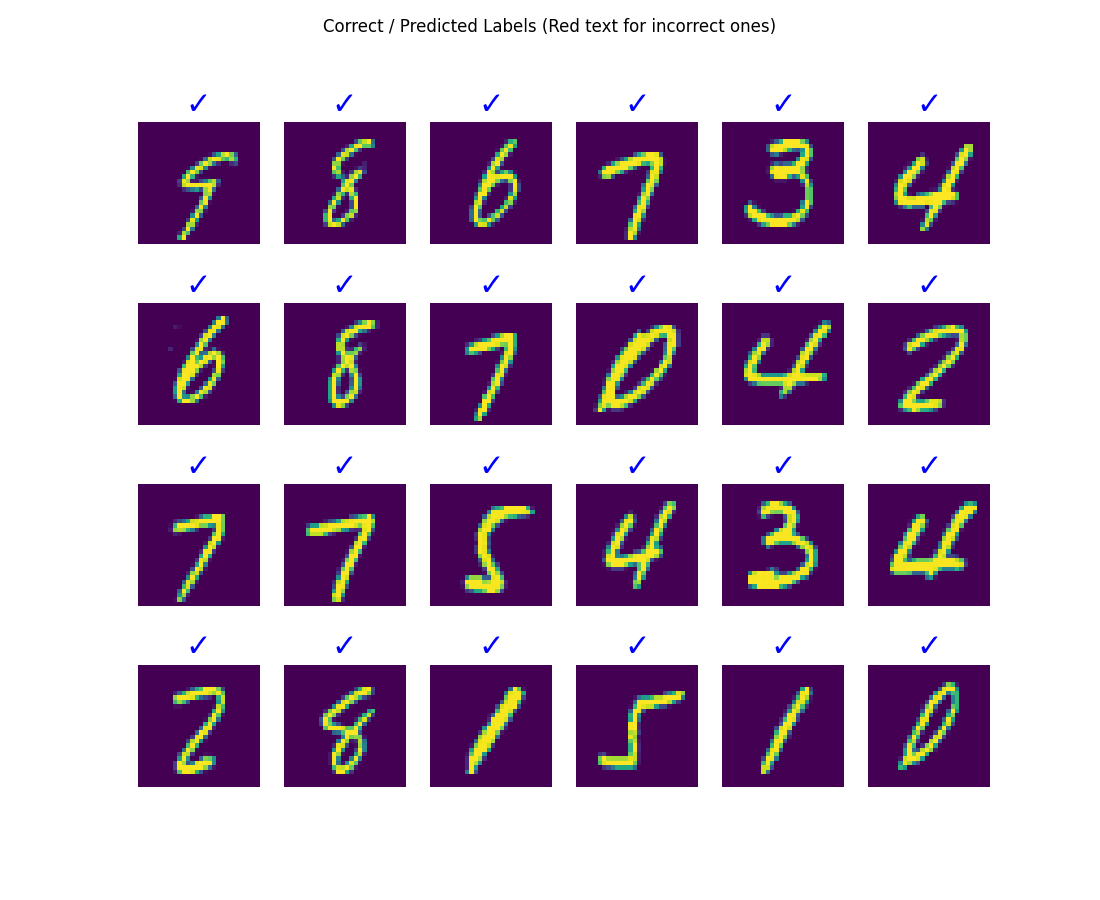

In [9]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)